### Step 4 - Linear Discriminant Analysis

#### This Python notebook will demonstrate how to use Linear Discriminant Analysis (PCA)

#### Similar to PCA, LDA is also a linear transformation technique, however PCA is unsupervised, while LDA is supervised

#### Additionally, here we show how you can extract Neuron IDs and image reconstructions of top cells based od LDA results.

#### The dataset used for PCA in this example is the NM_hippocampus_All_Glia.csv file that can be generated generated in Step 1 by selecting the following values:
- Brain Region: Hippocampus
- Species: All
- Cell Type: Glia

In [103]:
# Module importing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from PIL import Image
import requests

In [88]:
# Dataframe loading from the downloaded NM_hippocampus_All_Glia.csv file that can be generated in Step 1.
# Brain Region: hippocampus; species: all; cell type: glia.

df = pd.read_csv('NM_hippocampus_All_Glia.csv', index_col='Neuron ID')
df.shape

(7421, 61)

In [89]:
# Statistical description of numerical variables in the dataframe.

df.describe()

,Magnification,Slicing Thickness,Surface,Volume,Soma surface,Number of stems,Number of bifurcations,Number of branches,Width,Height,...,Path distance,Branching order,Contraction,Fragmentation,Partition asymmetry,Pk classic,Bifurcation angle local,Fractal dimension,Bifurcation angle remote,Length
count,7421.000000,7421.000000,7421.000000,7421.000000,6188.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,...,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000
mean,75.633338,93.811211,1025.974530,450.530896,185.672931,4.866999,45.607196,96.081391,44.224149,41.636042,...,66.387103,9.655168,0.872673,754.890177,0.511370,1.699704,73.889939,1.073652,74.297725,532.318713
std,30.786070,109.221726,3419.015757,6226.570183,437.953450,2.725732,50.650991,101.730714,30.744099,23.967061,...,146.379541,7.008337,0.077268,1226.705258,0.167808,0.643317,21.753374,0.050248,18.506950,505.224449
min,20.000000,16.000000,29.230200,0.511529,0.736151,1.000000,0.000000,2.000000,0.900000,1.520000,...,10.169300,0.000000,0.436335,7.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.081200
25%,63.000000,30.000000,295.542000,27.421300,101.773750,2.000000,15.000000,35.000000,28.070000,28.620000,...,42.384500,5.000000,0.852232,235.000000,0.448830,1.362180,60.477400,1.042530,65.297100,266.909000
50%,100.000000,70.000000,599.952000,95.512800,144.679000,5.000000,28.000000,62.000000,44.390000,37.720000,...,54.395300,8.000000,0.890060,458.000000,0.549802,1.708140,80.267300,1.060940,77.959600,417.950000
75%,100.000000,80.000000,1213.120000,245.082000,201.364750,7.000000,56.000000,117.000000,56.980000,50.100000,...,72.418400,12.000000,0.920923,823.000000,0.623230,2.000000,89.448300,1.087230,87.101000,651.881000
max,100.000000,450.000000,130062.000000,267878.000000,16274.400000,20.000000,454.000000,910.000000,586.220000,403.180000,...,10304.600000,84.000000,0.992024,19298.000000,0.857143,16.041500,148.711000,1.387460,166.676000,20756.100000


In [91]:
# Magnification and Slicing Thickness are numerical values, but are not of importance for LDA.
# Parameter 'Soma surface' is also being dropped out as it contain NaN values which can not be present for PCA

df = df.drop(columns=['Magnification', 'Slicing Thickness', 'Soma surface'])

In [92]:
# Checking again to see if we now have the desired variables for LDA

df.describe()

,Surface,Volume,Number of stems,Number of bifurcations,Number of branches,Width,Height,Depth,Diameter,Euclidian distance,Path distance,Branching order,Contraction,Fragmentation,Partition asymmetry,Pk classic,Bifurcation angle local,Fractal dimension,Bifurcation angle remote,Length
count,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000,7421.000000
mean,1025.974530,450.530896,4.866999,45.607196,96.081391,44.224149,41.636042,14.781682,0.516038,45.179366,66.387103,9.655168,0.872673,754.890177,0.511370,1.699704,73.889939,1.073652,74.297725,532.318713
std,3419.015757,6226.570183,2.725732,50.650991,101.730714,30.744099,23.967061,78.591144,0.395652,143.408717,146.379541,7.008337,0.077268,1226.705258,0.167808,0.643317,21.753374,0.050248,18.506950,505.224449
min,29.230200,0.511529,1.000000,0.000000,2.000000,0.900000,1.520000,0.000000,0.070000,5.828730,10.169300,0.000000,0.436335,7.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.081200
25%,295.542000,27.421300,2.000000,15.000000,35.000000,28.070000,28.620000,3.570000,0.302190,30.388700,42.384500,5.000000,0.852232,235.000000,0.448830,1.362180,60.477400,1.042530,65.297100,266.909000
50%,599.952000,95.512800,5.000000,28.000000,62.000000,44.390000,37.720000,7.000000,0.436139,37.951700,54.395300,8.000000,0.890060,458.000000,0.549802,1.708140,80.267300,1.060940,77.959600,417.950000
75%,1213.120000,245.082000,7.000000,56.000000,117.000000,56.980000,50.100000,16.180000,0.653875,47.133300,72.418400,12.000000,0.920923,823.000000,0.623230,2.000000,89.448300,1.087230,87.101000,651.881000
max,130062.000000,267878.000000,20.000000,454.000000,910.000000,586.220000,403.180000,5544.660000,7.414750,10272.900000,10304.600000,84.000000,0.992024,19298.000000,0.857143,16.041500,148.711000,1.387460,166.676000,20756.100000


In [93]:
# Instead of dropping out variables like we did for PCA in Step 3 we can create a new variable
# called usevars which will contain the numerical values for the morphometric parameters.

dfdescribe = df.describe()
dfdescribe
usevars = list(dfdescribe.columns)

In [94]:
# Obtaining the output results for each specific column from the dataframe.

def col_report(df, colname):
    print ('contents of', colname)
    for s in set(df[colname]):
        print ('   ', s, df[df[colname]==s].shape[0])

In [95]:
# Looking at the number of species in our dataframe.
# LDA example will be based on glial cells obtained from different species.

col_report(df, 'Species')

contents of Species
    guinea pig 73
    capuchin monkey 299
    Ruddy turnstone 392
    Semipalmated plover 501
    Semipalmated sandpiper 635
    rat 1768
    mouse 3571
    monkey 182


In [96]:
# Filtering for only cells from Control conditions.

df=df[df['Experiment Condition'].str.contains('Control')]
print (df.shape[0], 'cells')

3323 cells


In [97]:
# Use standard scaler to normalize the features/parameters in usevars variable.
# These will be plotted on the X axis, while the species will be plotted on the Y axis.

scaler = StandardScaler()

df[usevars] = scaler.fit_transform(df[usevars])

X = df[usevars].values
y = df[['Species']].values

2D LDA Analysis for glia cells by Species
   explained variance ratio (first two components): [0.47939838 0.2522914 ] 
   total = 0.7316897852032997


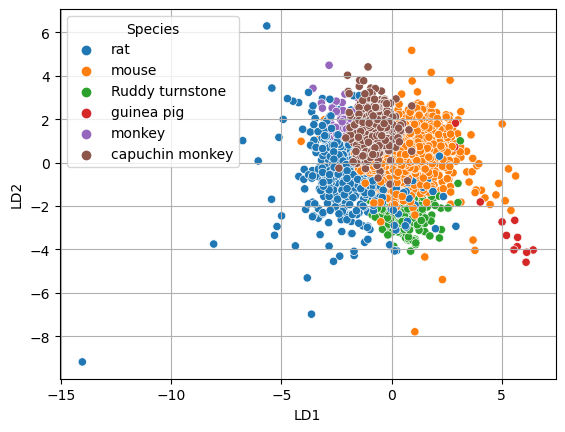

In [98]:
# Code for plotting the figure of LDA analysis.
# The LDA in this case is based on number of components = 2.
# Additionally, we generate the explained variance ratio for both LDA components.

print ('2D LDA Analysis for glia cells by Species')

lda = LinearDiscriminantAnalysis(n_components=2)
# this line need to eliminate a warning from sklearn
yr = np.ravel(y)
lda.fit(X, yr)

X_rlda = lda.transform(X)

print('   explained variance ratio (first two components): %s' # First two LDA components
      % str(lda.explained_variance_ratio_), '\n   total =', lda.explained_variance_ratio_.sum())

#put the LDs into columns in the df
df['LD1'] = X_rlda[:,0]
df['LD2'] = X_rlda[:,1]

f=sns.scatterplot(x='LD1', y='LD2', hue='Species', data=df).grid(True)
plt.show()

In [99]:
# This step correlates the 2 components with each morphometric parameter.
# It shows us the influence of these parameters on LDA. 

LD_corrs = df.corr()[['LD1', 'LD2']]
LD_corrs.drop(['LD1', 'LD2'], inplace=True)

LD_corrs.sort_values('LD1', inplace=True)
LD_corrs.round(3)

,LD1,LD2
Number of stems,-0.662,-0.024
Bifurcation angle local,-0.615,-0.129
Contraction,-0.379,0.198
Diameter,-0.279,0.019
Bifurcation angle remote,-0.241,0.258
Height,-0.216,0.490
Pk classic,-0.106,-0.109
Volume,-0.096,-0.019
Surface,-0.089,0.020
Width,-0.079,0.152


In [100]:
# The next par of this notebook is to obtain Neuron IDs and images of top cells based on the previous LDA analysis.
# This will be done by making centroids for different species present in our dataframe.
# Rat and monkey glial cells will be used as an example.

LDA = ['LD1', 'LD2']
species_centroid = pd.DataFrame(df[df['Species']=='rat'].mean(), columns = ['rat'])
species_centroid['mouse'] = df[df['Species']=='mouse'].mean()
species_centroid['Ruddy turnstone'] = df[df['Species']=='Ruddy turnstone'].mean()
species_centroid['guinea pig'] = df[df['Species']=='guinea pig'].mean()
species_centroid['monkey'] = df[df['Species']=='monkey'].mean()
species_centroid['capuchin monkey'] = df[df['Species']=='capuchin monkey'].mean()

# Show centroids for each species.
# These will be added as last two columns in the dataframe.
# Ignore the reported warning
species_centroid.tail(2) 

<ipython-input-100-1048b3479d43>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  species_centroid = pd.DataFrame(df[df['Species']=='rat'].mean(), columns = ['rat'])
<ipython-input-100-1048b3479d43>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  species_centroid['mouse'] = df[df['Species']=='mouse'].mean()
<ipython-input-100-1048b3479d43>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  species_centroid['Ruddy turnstone'] = df[df['Species']=='Ruddy turnstone'].mean()
<ipython-input-1

,rat,mouse,Ruddy turnstone,guinea pig,monkey,capuchin monkey
LD1,-1.891613,0.919736,0.386175,3.788847,-2.219135,-0.755291
LD2,-0.332871,0.290451,-1.993386,-1.325289,1.638055,1.537048


In [101]:
# Making a dataframe copy for rat cells only

df_rat = df[df['Species']=='rat'].copy() 

# Calculating the euclidean distance of each rat neuron from the centroid

tmp = df_rat[LDA] - species_centroid[['rat']].T[LDA].values[0]
df_rat['ED2centroid'] = (tmp*tmp).sum(axis=1)

# Sorting and displaying in ascending order of distance from the centroid.
# Top cells are most average cell type in that cluster.

df_rat.sort_values('ED2centroid').head()

,Neuron Name,Archive,Note,Age Scale,Gender,Age Classification,Brain Region,Cell Type,Species,Strain,...,Fragmentation,Partition asymmetry,Pk classic,Bifurcation angle local,Fractal dimension,Bifurcation angle remote,Length,LD1,LD2,ED2centroid
Neuron ID,,,,,,,,,,,,,,,,,,,,,
78508,CA3-01_6,Papageorgiou_Kann,GFAP staining,Not Reported,Male,adult,"['hippocampus', 'CA3']","['Glia', 'astrocyte']",rat,Wistar,...,-0.391271,-1.574395,-0.339913,0.395199,-0.343915,0.331498,0.005648,-1.912968,-0.358727,0.001125
127892,9_86,La Barbera,Parkinsons disease model carrying the full-len...,Month,Male/Female,adult,"['hippocampus', 'CA1', 'stratum radiatum']","['Glia', 'microglia', 'Iba1-positive']",rat,BAC-synuclein transgenic,...,0.009020,0.306279,0.531781,0.375633,-1.136772,0.187343,0.488415,-1.880469,-0.388537,0.003223
78782,slice-2_10,Papageorgiou_Kann,NaN,Day,Male,young,['hippocampus'],"['Glia', 'microglia', 'Iba1-positive']",rat,Wistar,...,-0.463697,0.194651,-0.379030,1.066658,-0.089602,0.026181,-0.456463,-1.882311,-0.395989,0.004070
127809,5-4_1,La Barbera,NaN,Month,Male/Female,adult,"['hippocampus', 'CA1', 'stratum radiatum']","['Glia', 'microglia', 'Iba1-positive']",rat,Sprague-Dawley,...,-0.400616,0.147098,0.520956,0.521993,-1.238639,0.573317,-0.457365,-1.886398,-0.404899,0.005215
127866,3-4_5,La Barbera,Parkinsons disease model carrying the full-len...,Month,Male/Female,adult,"['hippocampus', 'CA1', 'stratum radiatum']","['Glia', 'microglia', 'Iba1-positive']",rat,BAC-synuclein transgenic,...,-0.365571,-0.421412,0.520956,0.479049,-1.270696,0.347246,-0.270322,-1.814164,-0.363154,0.006915


In [102]:
# Getting Neuron IDs for top 5 rat cells

rat5 = list(df_rat.sort_values('ED2centroid').head().index)
df[usevars].loc[rat5] 

,Surface,Volume,Number of stems,Number of bifurcations,Number of branches,Width,Height,Depth,Diameter,Euclidian distance,Path distance,Branching order,Contraction,Fragmentation,Partition asymmetry,Pk classic,Bifurcation angle local,Fractal dimension,Bifurcation angle remote,Length
Neuron ID,,,,,,,,,,,,,,,,,,,,
78508,0.110338,-0.025910,0.914948,-0.463365,-0.436445,0.457733,-0.087476,-0.322147,0.945745,-0.014926,-0.046640,-0.908684,0.286245,-0.391271,-1.574395,-0.339913,0.395199,-0.343915,0.331498,0.005648
127892,-0.194111,-0.077277,0.914948,0.985206,1.010164,0.353026,-0.044166,0.133605,-0.880088,0.014962,0.070207,0.659917,1.512241,0.009020,0.306279,0.531781,0.375633,-1.136772,0.187343,0.488415
78782,-0.046506,-0.048163,0.914948,-0.716290,-0.689027,-0.164520,-0.696385,-0.235018,1.159374,-0.094006,-0.162624,-0.908684,0.330782,-0.463697,0.194651,-0.379030,1.066658,-0.089602,0.026181,-0.456463
127809,-0.219253,-0.077524,0.515425,-0.279420,-0.264229,-0.001151,-0.492701,-0.132352,-0.863116,-0.074074,-0.158803,-0.623484,1.641264,-0.400616,0.147098,0.520956,0.521993,-1.238639,0.573317,-0.457365
127866,-0.213699,-0.077463,-0.283622,-0.141460,-0.149419,0.400018,-0.059174,-0.206381,-0.863116,-0.036771,-0.090435,-0.480884,1.573936,-0.365571,-0.421412,0.520956,0.479049,-1.270696,0.347246,-0.270322


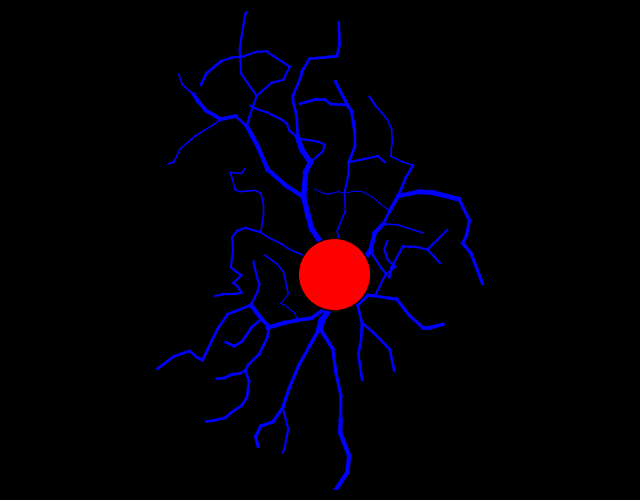

In [104]:
# In this step we will show how image reconstructions of these top 5 cells can be imported and shown inside this notebook. 

# Getting .png image files for top 5 cells
cells = []
for id in rat5:
    url = df.loc[id]['Png URL']
    cells.append(Image.open(requests.get(url, stream=True).raw))
    
# Show top 1 cell from rat 
#Changing the number in the cells[] shows other top cells

cells[0]

In [105]:
# If we want to make an image composition/plate of those 5 cells we can use the following function/code.
# The use 'horizontal' will make a row of images, while the use 'vertical' will make a column of images.

def append_images(images, direction='horizontal',
                  bg_color=(255,255,255), aligment='center'):
    """
    Appends images in horizontal/vertical direction.

    Args:
        images: List of PIL images
        direction: direction of concatenation, 'horizontal' or 'vertical'
        bg_color: Background color (default: white)
        aligment: alignment mode if images need padding;
           'left', 'right', 'top', 'bottom', or 'center'

    Returns:
        Concatenated image as a new PIL image object.
    """
    widths, heights = zip(*(i.size for i in images))

    if direction=='horizontal':
        new_width = sum(widths)
        new_height = max(heights)
    else:
        new_width = max(widths)
        new_height = sum(heights)

    new_im = Image.new('RGB', (new_width, new_height), color=bg_color)


    offset = 0
    for im in images:
        if direction=='horizontal':
            y = 0
            if aligment == 'center':
                y = int((new_height - im.size[1])/2)
            elif aligment == 'bottom':
                y = new_height - im.size[1]
            new_im.paste(im, (offset, y))
            offset += im.size[0]
        else:
            x = 0
            if aligment == 'center':
                x = int((new_width - im.size[0])/2)
            elif aligment == 'right':
                x = new_width - im.size[0]
            new_im.paste(im, (x, offset))
            offset += im.size[1]

    return new_im

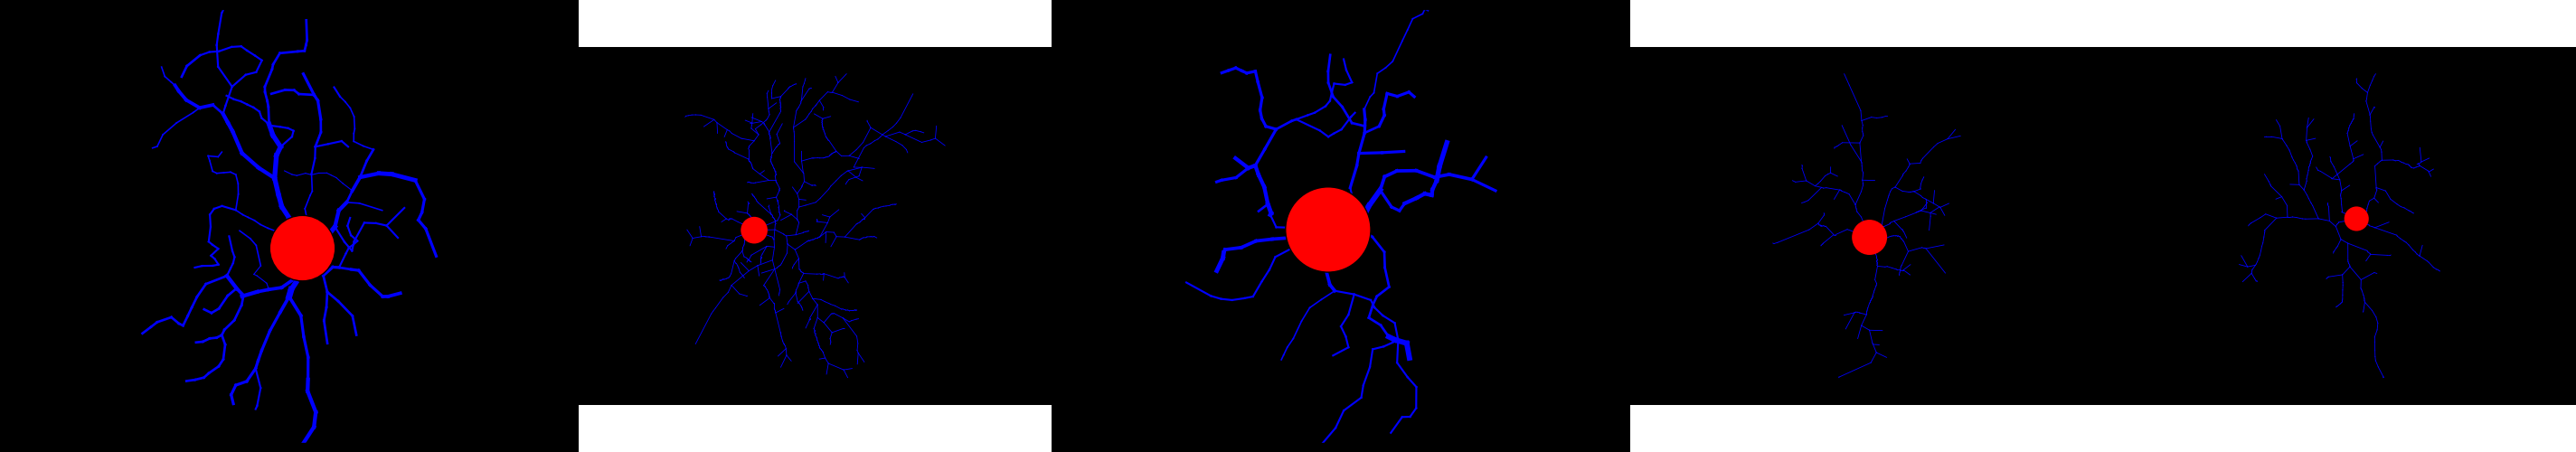

In [106]:
# Make plate of top 5 rat glial cells.

rat_top5 = append_images(cells, direction='horizontal')
rat_top5 #cell[1] is incomplete; cell[2] is sideways

In [107]:
# Example for monkey cells.
# The steps are the same as for the previosly described rat cells.

df_monkey = df[df['Species']=='monkey'].copy() #[usevars].shape

#calculate the euclidean distance of each CA3 neuron from the centroid
tmp = df_monkey[LDA] - species_centroid[['monkey']].T[LDA].values[0]
df_monkey['ED2centroid'] = (tmp*tmp).sum(axis=1)

#sort and disply in ascending order of distance from the centroid
df_monkey.sort_values('ED2centroid').head()

,Neuron Name,Archive,Note,Age Scale,Gender,Age Classification,Brain Region,Cell Type,Species,Strain,...,Fragmentation,Partition asymmetry,Pk classic,Bifurcation angle local,Fractal dimension,Bifurcation angle remote,Length,LD1,LD2,ED2centroid
Neuron ID,,,,,,,,,,,,,,,,,,,,,
73189,CNT-4-DG-POL-1-Cell-1,Diniz,NaN,Not Reported,Not reported,not reported,"['hippocampus', 'dentate gyrus', 'hilus']","['Glia', 'microglia', 'Type I']",monkey,callithrix penicillata,...,0.035498,0.015110,0.487252,0.128790,-0.222813,-0.599262,0.353283,-2.151770,1.559378,0.010728
73184,CNT-3-DG-POL-5-Cell-5,Diniz,NaN,Not Reported,Not reported,not reported,"['hippocampus', 'dentate gyrus', 'hilus']","['Glia', 'microglia', 'Type I']",monkey,callithrix penicillata,...,-0.098451,-0.101068,0.086892,0.669933,-0.062889,0.553001,0.133962,-2.082890,1.504034,0.036524
73202,CNT-4-DG-POL-3-Cell-3,Diniz,NaN,Not Reported,Not reported,not reported,"['hippocampus', 'dentate gyrus', 'hilus']","['Glia', 'microglia', 'Type I']",monkey,callithrix penicillata,...,0.116490,-0.184823,0.029140,0.362851,-0.024065,0.242231,0.378484,-2.042974,1.549964,0.038793
73206,CNT-4-DG-POL-4-Cell-2,Diniz,NaN,Not Reported,Not reported,not reported,"['hippocampus', 'dentate gyrus', 'hilus']","['Glia', 'microglia', 'Type I']",monkey,callithrix penicillata,...,0.028489,0.727700,0.377287,1.025471,-0.001269,0.689719,0.180111,-2.248105,1.879436,0.059104
73193,CNT-4-DG-POL-2-Cell-1,Diniz,NaN,Not Reported,Not reported,not reported,"['hippocampus', 'dentate gyrus', 'hilus']","['Glia', 'microglia', 'Type I']",monkey,callithrix penicillata,...,0.178014,0.350917,0.562769,0.448416,-0.043655,0.619762,0.507253,-2.462107,1.587979,0.061543


In [108]:
monkey5 = list(df_monkey.sort_values('ED2centroid').head().index)
df[usevars].loc[monkey5]  

,Surface,Volume,Number of stems,Number of bifurcations,Number of branches,Width,Height,Depth,Diameter,Euclidian distance,Path distance,Branching order,Contraction,Fragmentation,Partition asymmetry,Pk classic,Bifurcation angle local,Fractal dimension,Bifurcation angle remote,Length
Neuron ID,,,,,,,,,,,,,,,,,,,,
73189,-0.112217,-0.072320,1.314471,0.088472,0.126125,-0.332935,0.723403,-0.101583,-0.542457,-0.002824,-0.063771,-0.195684,0.705026,0.035498,0.015110,0.487252,0.128790,-0.222813,-0.599262,0.353283
73184,-0.121978,-0.072102,1.314471,-0.141460,-0.103495,-0.362266,0.447678,-0.113159,-0.473380,-0.025030,-0.056574,0.089517,0.478371,-0.098451,-0.101068,0.086892,0.669933,-0.062889,0.553001,0.133962
73202,-0.123606,-0.073815,1.713994,-0.003501,0.045758,0.037641,0.660797,-0.197547,-0.572619,-0.044982,-0.095982,-0.623484,0.073205,0.116490,-0.184823,0.029140,0.362851,-0.024065,0.242231,0.378484
73206,-0.135960,-0.074125,0.914948,-0.049488,-0.023128,-0.356274,0.942953,-0.188407,-0.551006,-0.015331,-0.036458,-0.338284,0.250628,0.028489,0.727700,0.377287,1.025471,-0.001269,0.689719,0.180111
73193,-0.110473,-0.073294,2.113518,0.364390,0.424632,0.096933,1.136775,-0.098536,-0.554797,0.002738,0.089615,0.374717,0.193927,0.178014,0.350917,0.562769,0.448416,-0.043655,0.619762,0.507253


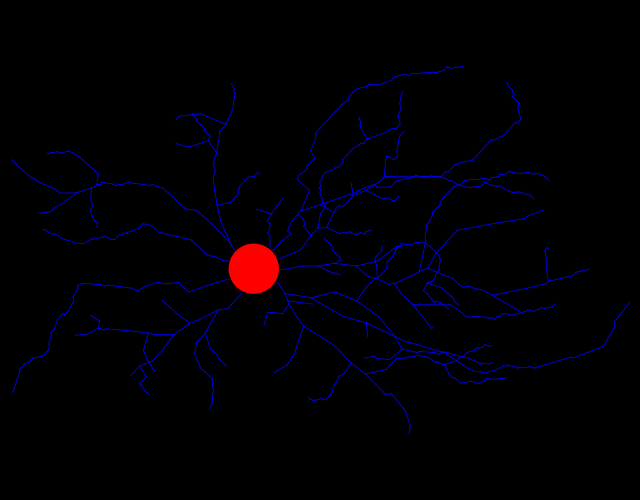

In [109]:
cells = []
for id in monkey5:
    url = df.loc[id]['Png URL']
    cells.append(Image.open(requests.get(url, stream=True).raw))
    
cells[0]

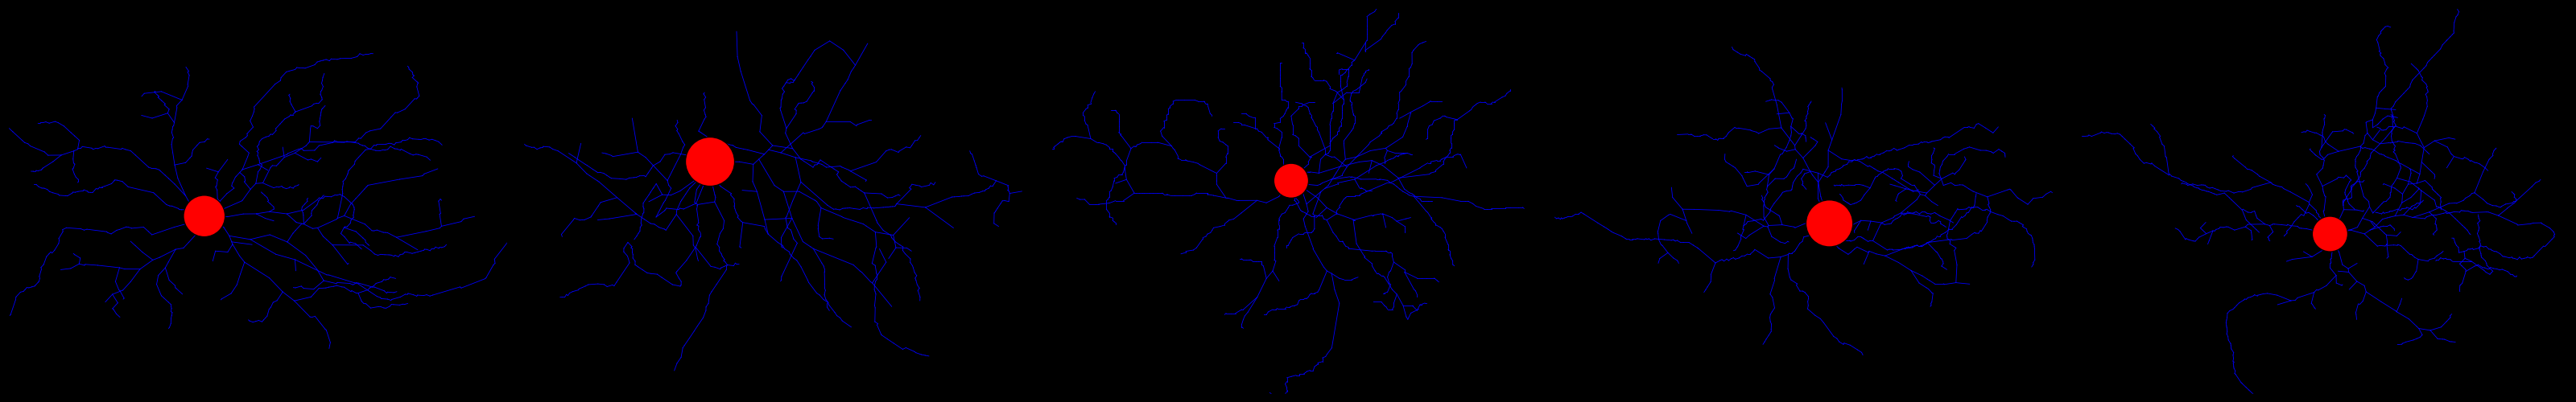

In [110]:
monkey_top5 = append_images(cells, direction='horizontal')
monkey_top5 